## PS 2 - Logistic Regression Classification
### "Whether or not patient should receive a treatment based on medical data"
### Deadline: **Thursday, February 25, 2021, 10 A.M PT**

I want you to design a model, that can **classify if a certain treatment is recommended for the patient or not**.
Additionally, there are 4 additional features (denoted as MeasureA, TestB, GeneA and GeneB
in your dataset) that we can use. However, they are really expensive and difficult to collect. I
want you to assess how useful they are. 

Hint: Your boss called your task “proof-of-concept”, but in fact, the nature of that assignment is the same
as the last time. You are asked to **train a classification model and you must measure how good that model
is**. Additionally, you must give **recommendations which features are important to collect**. You should look
at all variables, but at minimum, you should **test the importance of MeasureA, TestB, GeneA, and
GeneB**.

Your Technical Manager said: “This time it really matters, that your model has a good
performance. If we can show that our model makes less mistakes than a human doctor, it would
be a big deal. Describe exactly how you tested your model. They are really going to look at that
section. Additionally, similar to the last time, the interpretability of the model is very important.
You should **restrict yourself to logistic regression.**

Hint: Remember, that accuracy alone, is not a good measure. We care both, about **accuracy, precision
and F1-score**. Report also **false positive and false negative**. To choose a right model, you can use for
example the **AUC score**. It is ok (it's even expected) that you will do some **feature engineering**. You can
also try to add **regularization to your logistic regression** and test if it helps you or not. To show that the
model can be interpreted, you can **identify and explain the most important relations between the variables
and the expected outcome** (e.g., how the probability that the treatment is recommended changes with
age? Or gender?).

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy as sp 

from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

## modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('../data/ps2_public.csv')

In [4]:
df.head()

,treatment,age,blood_pressure,gender,blood_test,family_history,TestA,TestB,GeneC,GeneD,GeneE,GeneF
0,0,64,103.820809,non-female,negative,False,4.334376,0.324374,not active,1,1,0
1,0,52,107.071369,female,negative,False,0.361847,-0.213014,active,1,0,0
2,1,55,113.116130,female,positive,False,3.611842,-0.071740,not active,0,0,1
3,0,45,83.760932,female,negative,NaN,-5.282537,-0.237121,active,0,0,0
4,0,58,131.135933,female,negative,False,2.787207,0.195470,not active,0,1,1


In [5]:
df.shape

(7500, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   treatment       7500 non-null   int64  
 1   age             7500 non-null   int64  
 2   blood_pressure  7500 non-null   float64
 3   gender          7500 non-null   object 
 4   blood_test      7500 non-null   object 
 5   family_history  4893 non-null   object 
 6   TestA           7500 non-null   float64
 7   TestB           7500 non-null   float64
 8   GeneC           7500 non-null   object 
 9   GeneD           7500 non-null   int64  
 10  GeneE           7500 non-null   int64  
 11  GeneF           7500 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 703.2+ KB


In [7]:
df.describe()

,treatment,age,blood_pressure,TestA,TestB,GeneD,GeneE,GeneF
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,0.552533,59.978000,101.023910,3.983448,-0.000590,0.549467,0.550667,0.551200
std,0.497266,8.100115,36.128945,4.162343,0.171500,0.497580,0.497459,0.497405
min,0.000000,29.000000,-999.000000,-11.699344,-0.288422,0.000000,0.000000,0.000000
25%,0.000000,54.000000,91.802997,1.117443,-0.134452,0.000000,0.000000,0.000000
50%,1.000000,60.000000,99.814330,3.991237,-0.027296,1.000000,1.000000,1.000000
75%,1.000000,65.000000,110.095869,6.784449,0.101578,1.000000,1.000000,1.000000
max,1.000000,93.000000,157.471226,21.386412,0.740719,1.000000,1.000000,1.000000


In [8]:
## class proportions
df['treatment'].value_counts()

1    4144
0    3356
Name: treatment, dtype: int64

In [9]:
## check for missing vals
df.isnull().sum()

treatment            0
age                  0
blood_pressure       0
gender               0
blood_test           0
family_history    2607
TestA                0
TestB                0
GeneC                0
GeneD                0
GeneE                0
GeneF                0
dtype: int64

## Data preparation
1. Clean data: fill nans and remove outliers
2. Feature engineering: transform data, scale data, encode categorical vars, etc

In [10]:
## rem,ove fam history col
df.dropna(axis=1, inplace=True)

In [11]:
df.head()

,treatment,age,blood_pressure,gender,blood_test,TestA,TestB,GeneC,GeneD,GeneE,GeneF
0,0,64,103.820809,non-female,negative,4.334376,0.324374,not active,1,1,0
1,0,52,107.071369,female,negative,0.361847,-0.213014,active,1,0,0
2,1,55,113.116130,female,positive,3.611842,-0.071740,not active,0,0,1
3,0,45,83.760932,female,negative,-5.282537,-0.237121,active,0,0,0
4,0,58,131.135933,female,negative,2.787207,0.195470,not active,0,1,1


In [19]:
## Exploration
def make_histograms(dataframe, features, rows, cols):
    fig = plt.figure(figsize=(15,15))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins=30, ax=ax)
        ax.set_title(feature + " Distribution")
    fig.tight_layout()  

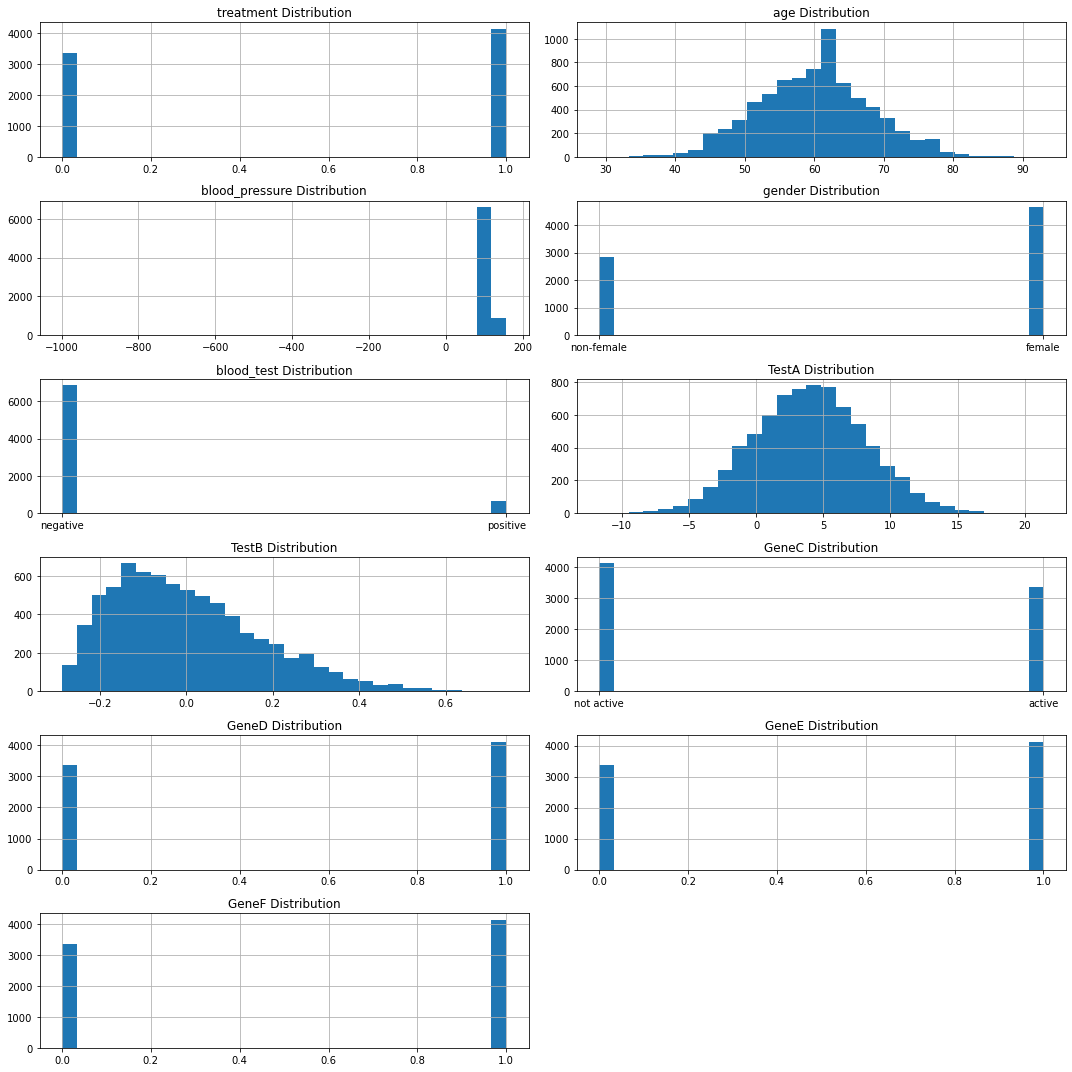

In [20]:
make_histograms(df,df.columns,6,2)

In [27]:
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

In [28]:
## TRANSFORM STEP 
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])


pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_cols),
    ("categorical", OneHotEncoder(), cat_cols)
])

arr = pipeline.fit_transform(df)  ### dropped dummy vars
print(arr.shape) # After outlier removal

(7500, 14)


In [30]:
df.head()

,treatment,age,blood_pressure,gender,blood_test,TestA,TestB,GeneC,GeneD,GeneE,GeneF
0,0,64,103.820809,non-female,negative,4.334376,0.324374,not active,1,1,0
1,0,52,107.071369,female,negative,0.361847,-0.213014,active,1,0,0
2,1,55,113.116130,female,positive,3.611842,-0.071740,not active,0,0,1
3,0,45,83.760932,female,negative,-5.282537,-0.237121,active,0,0,0
4,0,58,131.135933,female,negative,2.787207,0.195470,not active,0,1,1


In [33]:
X = arr[:,1:]
y = arr[:,0]
X.shape, y.shape

((7500, 13), (7500,))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

AttributeError: 'str' object has no attribute 'decode'